In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

In [2]:
train = pd.read_csv("data/train_prepared.csv")
test = pd.read_csv("data/test_prepared.csv")

In [3]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,15730.0,NaN,NaN,NaN,10479.541577,6080.166276,3.0,5212.0,10458.5,15766.75,20973.0
Rating,15730.0,NaN,NaN,NaN,4.012873,0.29844,0.0,3.9,4.0,4.2,5.0
MainCategory,15730,2,Women,8819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plateform,15730,2,Flipkart,15389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActingPrice,15730.0,NaN,NaN,NaN,1369.286777,1240.900227,42.0,699.0,999.0,1299.0,13499.0
Offer,15730.0,NaN,NaN,NaN,46.802491,19.268675,0.0,35.94,50.07,60.16,88.93
NumberOfRatings,15730.0,NaN,NaN,NaN,3074.681055,11915.323486,0.0,64.0,311.0,1527.75,289973.0
NumberOfReviews,15730.0,NaN,NaN,NaN,426.252702,1753.202101,0.0,9.0,44.0,215.0,45448.0
5Star,15730.0,NaN,NaN,NaN,1599.965035,6233.811271,0.0,30.0,153.0,789.0,151193.0
4Star,15730.0,NaN,NaN,NaN,662.491545,2843.657075,0.0,12.0,61.0,304.0,74037.0


In [4]:
test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,5244.0,NaN,NaN,NaN,10507.372616,5978.658892,0.0,5286.75,10561.5,15636.75,20964.0
Rating,5244.0,NaN,NaN,NaN,4.01558,0.311346,0.0,3.9,4.0,4.2,5.0
MainCategory,5244,2,Women,3034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plateform,5244,2,Flipkart,5140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActingPrice,5244.0,NaN,NaN,NaN,1378.657895,1280.63007,139.0,699.0,999.0,1299.0,15999.0
NumberOfRatings,5244.0,NaN,NaN,NaN,2988.580092,12881.253715,1.0,66.0,307.0,1428.0,289973.0
NumberOfReviews,5244.0,NaN,NaN,NaN,415.491037,1910.726669,0.0,9.0,44.0,214.25,45448.0
5Star,5244.0,NaN,NaN,NaN,1545.586003,6544.085444,0.0,32.0,156.0,756.5,151193.0
4Star,5244.0,NaN,NaN,NaN,639.785469,2991.065223,0.0,12.0,61.0,310.25,74037.0
3Star,5244.0,NaN,NaN,NaN,356.356789,1632.732834,0.0,7.0,34.0,166.0,49924.0


In [5]:
train.dtypes

ID                   int64
Rating             float64
MainCategory        object
Plateform           object
ActingPrice          int64
Offer              float64
NumberOfRatings    float64
NumberOfReviews    float64
5Star              float64
4Star              float64
3Star              float64
2Star                int64
1Star                int64
Fulfilled            int64
Combo                 bool
Category            object
dtype: object

In [6]:
train.columns

Index(['ID', 'Rating', 'MainCategory', 'Plateform', 'ActingPrice', 'Offer',
       'NumberOfRatings', 'NumberOfReviews', '5Star', '4Star', '3Star',
       '2Star', '1Star', 'Fulfilled', 'Combo', 'Category'],
      dtype='object')

In [7]:
train.drop("ID", axis=1, inplace=True)
test_id = test.ID
test.drop("ID", axis=1, inplace=True)

X = train.drop(["Offer"], axis=1)
y = train["Offer"]
assert X.shape[1] == test.shape[1], "X and test have different number of columns"

In [8]:
X["5Minus1"] = X["5Star"] - X["1Star"]
X["5Minus2"] = X["5Star"] - X["2Star"]
X["5Minus3"] = X["5Star"] - X["3Star"]
X["5Minus4"] = X["5Star"] - X["4Star"]
X["4Minus1"] = X["4Star"] - X["1Star"]
X["3Minus1"] = X["3Star"] - X["1Star"]
X["2Minus1"] = X["2Star"] - X["1Star"]

test["5Minus1"] = test["5Star"] - test["1Star"]
test["5Minus2"] = test["5Star"] - test["2Star"]
test["5Minus3"] = test["5Star"] - test["3Star"]
test["5Minus4"] = test["5Star"] - test["4Star"]
test["4Minus1"] = test["4Star"] - test["1Star"]
test["3Minus1"] = test["3Star"] - test["1Star"]
test["2Minus1"] = test["2Star"] - test["1Star"]

In [9]:
columns_to_one_hot = ["MainCategory", "Category", "Plateform", "Combo"]
# columns_to_polynomial = ["Price", "Size", "Age", "Publisher", "Developer", "Publisher_and_Developer", "Publisher_and_Developer_and_Age"]
columns_to_standardize = ["ActingPrice", 'NumberOfRatings', 'NumberOfReviews', '5Star', 
    '4Star', '3Star', '2Star', '1Star',"5Minus1", "5Minus2", "5Minus3", "5Minus4", "4Minus1", "3Minus1", "2Minus1"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
len(X_train),len(X_test)

(14157, 1573)

In [12]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)
standardizer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one_hot_encoder", one_hot_encoder, columns_to_one_hot),
        ("standardizer", standardizer, columns_to_standardize)],
    remainder="passthrough"
)

In [13]:
X_transformed = preprocessor.fit_transform(X)
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
test_final = preprocessor.transform(test)

In [14]:
assert X_train.shape[1] == test_final.shape[1], "X_train and test have different number of columns"

# Models

## Base Model

In [19]:
def evaluate(model, on="test"):
    if on == "test":
        X, y = X_test, y_test
    else:
        X, y = X_train, y_train
    y_pred = model.predict(X)
    print("-----------------------------------------------------")
    print("R2:", r2_score(y, y_pred))
    print("MSE:", mean_squared_error(y, y_pred))
    print("MAE:", mean_absolute_error(y, y_pred))
    print("RMSE:", mean_squared_error(y, y_pred) ** 0.5)
    print("-----------------------------------------------------")
    return y_pred

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = evaluate(lr)

-----------------------------------------------------
R2: 0.15652372225723143
MSE: 296.75870980914505
MAE: 13.878081492371265
RMSE: 17.22668597871178
-----------------------------------------------------


In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = evaluate(lr)

-----------------------------------------------------
R2: 0.15869169954340134
MSE: 295.99595434190053
MAE: 13.854730510966307
RMSE: 17.2045329591332
-----------------------------------------------------


In [19]:
xgbr = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.05)
xgbr.fit(X_train, y_train)
y_pred = evaluate(xgbr, on="test")
y_pred_t = evaluate(xgbr, on="train")

-----------------------------------------------------
R2: 0.7504613214421156
MSE: 87.79473501553568
MAE: 6.317080747223136
RMSE: 9.369884471835055
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9145532385732841
MSE: 31.906168977996273
MAE: 3.8967196231618573
RMSE: 5.648554591928476
-----------------------------------------------------


In [48]:
xgbr = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.05)
xgbr.fit(X_train, y_train)
y_pred = evaluate(xgbr, on="test")
y_pred_t = evaluate(xgbr, on="train")

-----------------------------------------------------
R2: 0.7471895302116716
MSE: 88.94584331571191
MAE: 6.429136706880908
RMSE: 9.431110396751377
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9009702235747971
MSE: 36.978122139662645
MAE: 4.215822702831295
RMSE: 6.080963915339627
-----------------------------------------------------


In [20]:
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=5, learning_rate=0.05)
gbr.fit(X_train, y_train)
y_pred = evaluate(gbr, on="test")
y_pred_t = evaluate(gbr, on="train")

-----------------------------------------------------
R2: 0.77711127289397
MSE: 78.41853153712498
MAE: 5.609923975155161
RMSE: 8.855423848530627
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9630488357623656
MSE: 13.797715330742047
MAE: 2.5461556850893037
RMSE: 3.7145276053277687
-----------------------------------------------------


In [66]:
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=5, learning_rate=0.05)
gbr.fit(X_train, y_train)
y_pred = evaluate(gbr, on="test")
y_pred_t = evaluate(gbr, on="train")

-----------------------------------------------------
R2: 0.7709768248763568
MSE: 80.57680311764872
MAE: 5.741540995019667
RMSE: 8.976458272484127
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9524151757752702
MSE: 17.768367310265063
MAE: 2.8654365907827986
RMSE: 4.215254121671084
-----------------------------------------------------


In [36]:
xgbr = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.04)
xgbr.fit(X_train, y_train)
y_pred = evaluate(xgbr, on="test")
y_pred_t = evaluate(xgbr, on="train")

-----------------------------------------------------
R2: 0.8187848800080694
MSE: 63.756582877028976
MAE: 4.505383969415393
RMSE: 7.984771936444332
-----------------------------------------------------
-----------------------------------------------------
R2: 0.989265978108092
MSE: 4.00812752383201
MAE: 1.1802508370583265
RMSE: 2.0020308498702035
-----------------------------------------------------


In [29]:
rfr = RandomForestRegressor(max_depth=20, n_estimators=5000, random_state=42)
rfr.fit(X_train, y_train)
y_pred = evaluate(rfr, on="test")
y_pred_t = evaluate(rfr, on="train")

-----------------------------------------------------
R2: 0.7898147397802333
MSE: 73.94909411161815
MAE: 5.390325749425473
RMSE: 8.599365913346062
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9496255781758686
MSE: 18.810014423637035
MAE: 2.897887287506331
RMSE: 4.337051351279696
-----------------------------------------------------


In [31]:
hr = HistGradientBoostingRegressor(max_depth=30, max_iter=4000, learning_rate=0.1, max_leaf_nodes=None, random_state=42)
hr.fit(X_train, y_train)
y_pred = evaluate(hr, on="test")
y_pred_t = evaluate(hr, on="train")

-----------------------------------------------------
R2: 0.7808477625159906
MSE: 77.10392925522858
MAE: 4.972703936817241
RMSE: 8.780884309409194
-----------------------------------------------------
-----------------------------------------------------
R2: 0.960914345475913
MSE: 14.594742703392743
MAE: 1.6454346102612163
RMSE: 3.8203066242636523
-----------------------------------------------------


In [52]:
rfr = RandomForestRegressor(max_depth=10, n_estimators=3000, random_state=42)
rfr.fit(X_train, y_train)
y_pred = evaluate(rfr, on="test")
y_pred_t = evaluate(rfr, on="train")

-----------------------------------------------------
R2: 0.5923970749471805
MSE: 143.40618858518383
MAE: 9.001710172436413
RMSE: 11.975232297754555
-----------------------------------------------------
-----------------------------------------------------
R2: 0.6483821554259253
MSE: 131.29553627706684
MAE: 8.650465239083692
RMSE: 11.458426431105924
-----------------------------------------------------


In [35]:
svr = SVR(kernel="rbf", C=1e3, gamma=0.2)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
print("svr On Test Set:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred)**0.5)
print("\n")
print("svr On Train Set:")
y_pred_t = svr.predict(X_train)
print("R2:", r2_score(y_train, y_pred_t))
print("MAE:", mean_absolute_error(y_train, y_pred_t))
print("RMSE:", mean_squared_error(y_train, y_pred_t)**0.5)

svr On Test Set:
R2: 0.8587907093645688
MAE: 137.74941703270449
RMSE: 255.50752140688238


svr On Train Set:
R2: 0.8514367193952317
MAE: 134.092849309882
RMSE: 247.25451472893542


In [38]:
xgbr = XGBRegressor(learning_rate=0.3, max_depth=4, n_estimators=1000, booster="gbtree")
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
print("XGBR On Test Set:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred)**0.5)
print("\n")
print("XGBR On Train Set:")
y_pred_t = xgbr.predict(X_train)
print("R2:", r2_score(y_train, y_pred_t))
print("MAE:", mean_absolute_error(y_train, y_pred_t))
print("RMSE:", mean_squared_error(y_train, y_pred_t)**0.5)

XGBR On Test Set:
R2: 0.9094067675501246
MAE: 97.86719559986578
RMSE: 204.65385576197573


XGBR On Train Set:
R2: 0.991287236873442
MAE: 37.40795654774622
RMSE: 59.877883827092134


In [21]:
import numpy as np
y_pred = np.abs(xgbr.predict(X_test))
print("XGBR On Test Set:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("\n")
print("XGBR On Train Set:")
y_pred_t = np.abs(xgbr.predict(X_train))
print("R2:", r2_score(y_train, y_pred_t))
print("MAE:", mean_absolute_error(y_train, y_pred_t))
print("MSE:", mean_squared_error(y_train, y_pred_t))

XGBR On Test Set:
R2: 0.9094067675501246
MAE: 97.86719559986578
MSE: 41883.20067824357


XGBR On Train Set:
R2: 0.991287236873442
MAE: 37.40795654774622
MSE: 3585.360971610742


In [15]:
from sklearn.ensemble import VotingRegressor

In [16]:
rfr = RandomForestRegressor(max_depth=20, n_estimators=4000, random_state=42)
hr = HistGradientBoostingRegressor(max_depth=30, max_iter=4000, learning_rate=0.1, max_leaf_nodes=None, random_state=42)
xgbr = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.05)
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=5, learning_rate=0.05)

In [17]:
vr = VotingRegressor(
    estimators=[
        ("xgbr", xgbr),
        ("rfr", rfr),
        ("hr", hr),
        ("gbr", gbr),
    ],
    weights=[1, 1, 1, 1],
)
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('xgbr',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05,
                                          max_delta_step=None, max_depth=10,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                        

In [20]:
_ =evaluate(vr, on="test")
_= evaluate(vr, on="train")

-----------------------------------------------------
R2: 0.8107805006711655
MSE: 66.57274895961203
MAE: 4.840962669793544
RMSE: 8.159212520801994
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9787192450717541
MSE: 7.9463206256480525
MAE: 1.8275398723851533
RMSE: 2.818921890661047
-----------------------------------------------------


In [69]:
_ =evaluate(vr, on="test")
_= evaluate(vr, on="train")

-----------------------------------------------------
R2: 0.8186822161361071
MSE: 63.792702918565936
MAE: 4.72033772660053
RMSE: 7.9870334241547996
-----------------------------------------------------
-----------------------------------------------------
R2: 0.9817414735926816
MSE: 6.817808178028412
MAE: 1.6848965482208873
RMSE: 2.611093291712958
-----------------------------------------------------


In [21]:
preds = vr.predict(test_final)
# preds = np.abs(preds)

In [22]:
preds.min(), preds.max()

(-0.8503780976472777, 83.53531627452894)

In [23]:
sample = pd.read_csv('data/Sample__submission.csv')

In [24]:
sample.head()

,id,price1
0,19841,193
1,19157,340
2,19445,637
3,8046,679
4,4571,190


In [25]:
act_price = test["ActingPrice"]
act_price

0        999
1        499
2        999
3       2999
4        999
        ... 
5239     699
5240    1993
5241     999
5242     499
5243     749
Name: ActingPrice, Length: 5244, dtype: int64

In [26]:
sub = pd.DataFrame({"id": test_id, "price2": preds})
sub

,id,price2
0,2242,57.694691
1,20532,43.275732
2,10648,54.217753
3,20677,67.184241
4,12593,60.013047
...,...,...
5239,14033,50.730786
5240,297,49.820553
5241,18733,60.695086
5242,6162,59.024062


In [27]:
sub["price2"] = (act_price-sub["price2"]*act_price/100).astype(int)
sub.head()

,id,price2
0,2242,422
1,20532,283
2,10648,457
3,20677,984
4,12593,399


In [28]:
sub = pd.merge(sample, sub, on="id")
sub.drop("price1", axis=1, inplace=True)
sub.columns = ["id", "price1"]
sub.head()

,id,price1
0,19841,773
1,19157,657
2,19445,199
3,8046,399
4,4571,1418


In [29]:
def get_good_price(price):
    if price < 0:
        price = np.abs(price)
    price_str = str(price)
    if len(price_str) <=2:
        return price
    last_digit = price_str[-1]
    last_last_digit = price_str[-2]
    other_digits = price_str[:-2]
    if int(last_digit)>=5:
        last_digit = 9
    else:
        last_digit = 9
        if last_last_digit == "0":
            last_digit = 0
            last_last_digit = 0
        else:
            last_last_digit = int(last_last_digit) - 1
    new_price = int(other_digits + str(last_last_digit) + str(last_digit))
    return new_price

In [30]:
sub["price1"] = sub["price1"].apply(get_good_price)

In [31]:
sub.to_csv("data/submission_using_offer.csv", index=False)

In [32]:
!kaggle competitions submit -c sa2022 -f data/submission_using_offer.csv -m ""

/bin/bash: line 1: kaggle: command not found


In [33]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model

In [35]:
X_train.shape

(14157, 33)

In [53]:
input = tfl.Input(shape=(X_train.shape[1],))
x = tfl.Dense(100, activation="relu")(input)
x = tfl.Dense(200, activation="relu")(x)
x = tfl.Dense(300, activation="relu")(x)
x = tfl.Dense(400, activation="relu")(x)
x = tfl.Dense(100, activation="relu")(x)
output = tfl.Dense(1, activation="linear")(x)
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_23 (Dense)            (None, 100)               3400      
                                                                 
 dense_24 (Dense)            (None, 200)               20200     
                                                                 
 dense_25 (Dense)            (None, 300)               60300     
                                                                 
 dense_26 (Dense)            (None, 400)               120400    
                                                                 
 dense_27 (Dense)            (None, 100)               40100     
                                                                 
 dense_28 (Dense)            (None, 1)                 101 

In [58]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

In [59]:
model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 4ms/step - loss: 120.9154


120.91536712646484

In [60]:
model.evaluate(X_train, y_train)

443/443 [==============================] - 1s 2ms/step - loss: 68.6097


68.60972595214844

<AxesSubplot:>

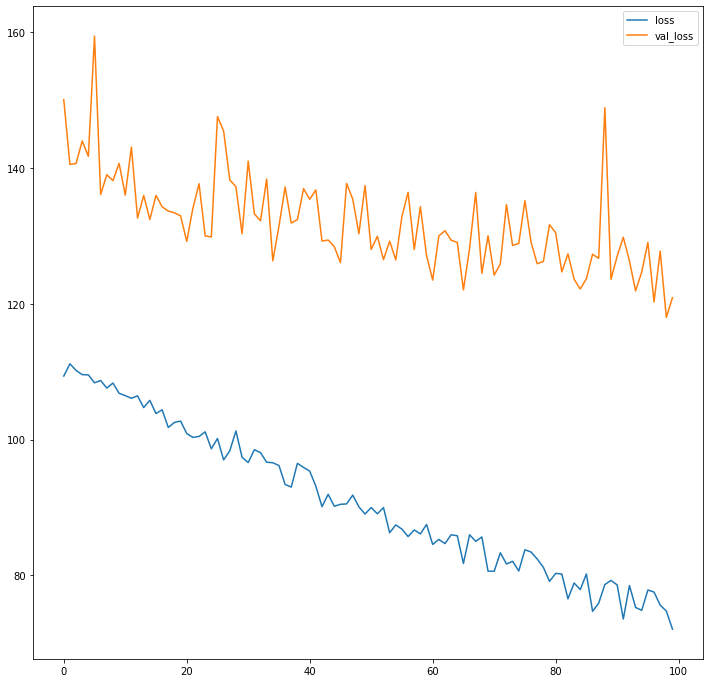

In [61]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(12, 12))